In [2]:
import scipy
# os walk
import os
import numpy as np
i = 0
dataset_x = []
dataset_y = [] # 列表


for name in ["xg", "yd", "zj"]:
    names = os.listdir(name)
    for filename in names:
        mat = scipy.io.loadmat(name + "/" + filename)["win"]
        # 删除nan的列
        nan_mask = np.isnan(mat)
        row_with_nan = np.any(nan_mask, axis=1)
        mat = mat[~row_with_nan]
        print(name + "/" + filename, mat.shape)
        
        dataset_x.append(mat)
        dataset_y.append(np.ones(mat.shape[0]) * i)
    i = i+1
dataset_x = np.concatenate(dataset_x, axis=0)
dataset_y = np.concatenate(dataset_y, axis=0)
    
# 打乱dataset
np.random.seed(0)
shuffle_index = np.random.permutation(dataset_x.shape[0])
dataset_x = dataset_x[shuffle_index]
dataset_y = dataset_y[shuffle_index]





xg/xg1.mat (224, 24)
xg/xg2.mat (218, 24)
xg/xg3.mat (242, 24)
xg/xg4.mat (247, 24)
xg/xg5.mat (254, 24)
yd/yd1.mat (224, 24)
yd/yd2.mat (260, 24)
yd/yd3.mat (278, 24)
yd/yd4.mat (260, 24)
yd/yd5.mat (272, 24)
yd/yd6.mat (242, 24)
zj/zj1.mat (1907, 24)
zj/zj2.mat (1081, 24)
zj/zj3.mat (1261, 24)
zj/zj4.mat (1503, 24)
zj/zj5.mat (1237, 24)


In [3]:
import torch
import torch.nn as nn  
import torch.optim as optim
sample_nums = 7000
from torch.utils.data import Dataset, DataLoader


class TensorDataset(Dataset):
    def __init__(self, data, label, regression: bool = False):
        self.data = data
        if regression:
            self.label = label
        else:
            self.label = torch.eye(3)[label.long()]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return (self.data[index], 
                self.label[index])
        

batch_size = 32

dataset = TensorDataset(torch.tensor(dataset_x[:sample_nums], dtype=torch.float32), torch.tensor(dataset_y[:sample_nums], dtype=torch.float32))
collect_fn = lambda x: (torch.stack([i[0] for i in x]), torch.stack([i[1] for i in x]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collect_fn)

testdata = TensorDataset(torch.tensor(dataset_x[sample_nums:], dtype=torch.float32), torch.tensor(dataset_y[sample_nums:], dtype=torch.float32))
testloader = DataLoader(testdata, batch_size=batch_size, shuffle=False, collate_fn=collect_fn)


# 使用交叉熵损失

8
error rate:  0.002952029520295203


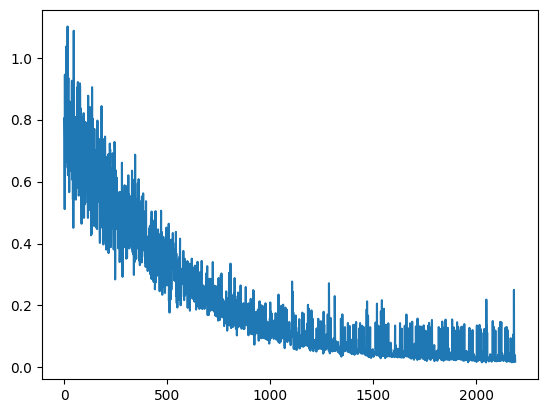

8
error rate:  0.002952029520295203


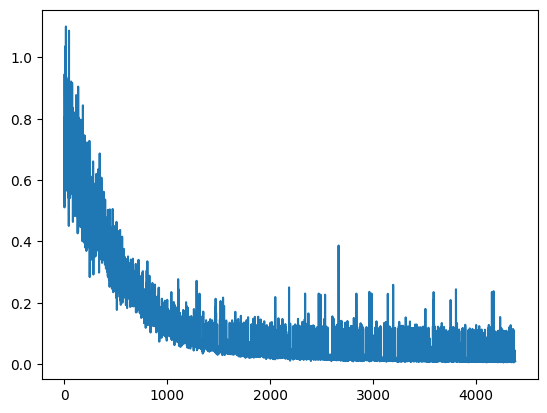

8
error rate:  0.002952029520295203


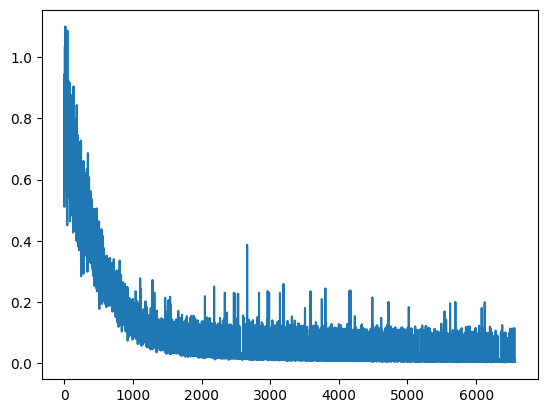

8
error rate:  0.002952029520295203


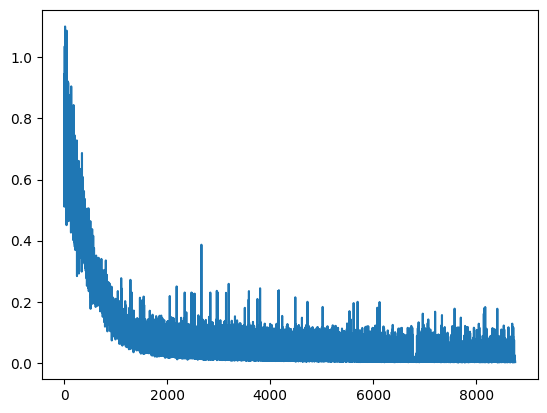

8
error rate:  0.002952029520295203


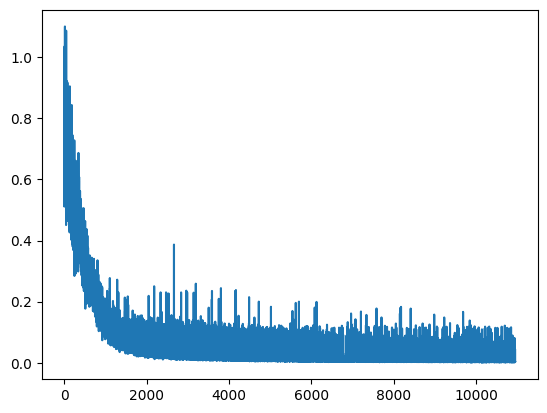

7
error rate:  0.0025830258302583027


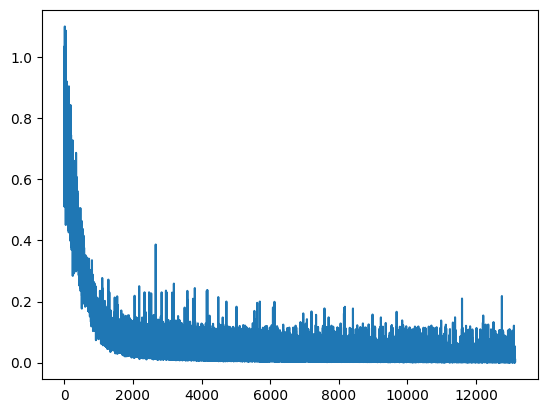

7
error rate:  0.0025830258302583027


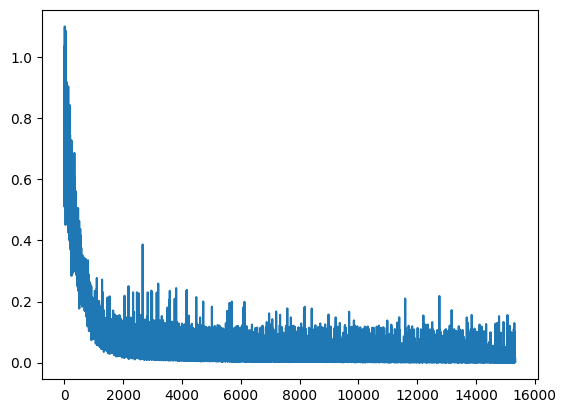

7
error rate:  0.0025830258302583027


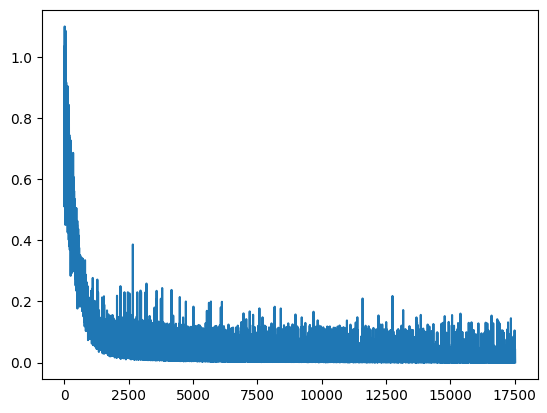

8
error rate:  0.002952029520295203


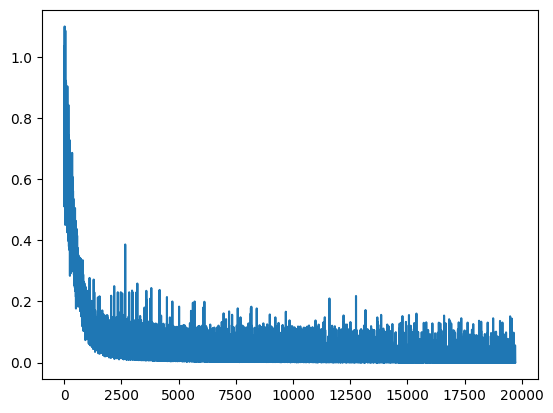

9
error rate:  0.0033210332103321034


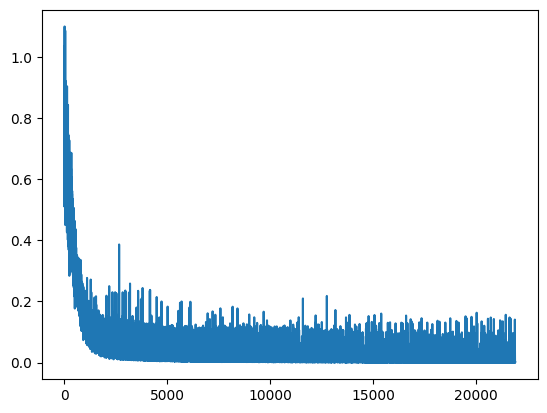

In [6]:
from model import MLP
from fasterkan.fasterkan import FasterKAN, FasterKANvolver
architecture = "KAN"
num_hidden = 64; bool_flag = True
if architecture == "MLP":
    model = MLP(dim_in = 24, dim_out = 3, hidden_dim=num_hidden, hidden_num=3)
if architecture == "KAN":
    model = FasterKAN([24, num_hidden,  3], grid_min = -1.2, grid_max = 0.2, num_grids = 8, exponent = 2, inv_denominator = 0.5, train_grid = bool_flag, train_inv_denominator = bool_flag)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# 定义损失函数和优化器
# mse
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
from matplotlib import pyplot as plt
# 训练模型
num_epochs = 100
losses = []
def class_error(outputs, labels):
    predict = torch.argmax(outputs, dim=1)
    label = torch.argmax(labels, dim=1)
    return torch.sum(predict != label).item()

error = class_error
for epoch in range(num_epochs):
    for batch in dataloader:
        # 前向传播
        inputs = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    
    
    if (epoch+1) % 10 == 0:
    
        # validate
        errors = 0;

        for batch in testloader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(inputs)
            errors += error(outputs, labels)
        print(errors)

        print("error rate: ", errors / len(testdata))
        
        plt.plot(losses)
        plt.show()


# 使用MSE损失

In [ ]:
dataset = TensorDataset(torch.tensor(dataset_x[:sample_nums], dtype=torch.float32), torch.tensor(dataset_y[:sample_nums], dtype=torch.float32)
                        , regression=True)
collect_fn = lambda x: (torch.stack([i[0] for i in x]), torch.stack([i[1] for i in x]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collect_fn)

testdata = TensorDataset(torch.tensor(dataset_x[sample_nums:], dtype=torch.float32), torch.tensor(dataset_y[sample_nums:], dtype=torch.float32),
                         regression=True)
testloader = DataLoader(testdata, batch_size=batch_size, shuffle=False, collate_fn=collect_fn)
architecture = "KAN"
num_hidden = 1024; bool_flag = True
if architecture == "MLP":
    model = MLP(dim_in = 24, dim_out =1, hidden_dim=num_hidden, hidden_num=3)
if architecture == "KAN":
    model = FasterKAN([24, num_hidden,  1], grid_min = -1.2, grid_max = 0.2, num_grids = 8, exponent = 2, inv_denominator = 0.5, train_grid = bool_flag, train_inv_denominator = bool_flag)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# 定义损失函数和优化器
# mse
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
from matplotlib import pyplot as plt
# 训练模型
num_epochs = 100
losses = []
def reg_error(outputs, labels):
    return torch.sum(torch.abs(outputs - labels) > 0.5).item()

error = reg_error
for epoch in range(num_epochs):
    for batch in dataloader:
        # 前向传播
        inputs = batch[0].to(device)
        labels = batch[1].reshape(-1,1).to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    
    
    if (epoch+1) % 10 == 0:
    
        # validate
        errors = 0;
        for batch in testloader:
            inputs = batch[0].to(device)
            labels =  batch[1].reshape(-1,1).to(device)
            outputs = model(inputs)
            errors += error(outputs, labels)
        print(errors)

        print("error rate: ", errors / len(testdata))
        
        plt.plot(losses)
        plt.show()


In [2]:
import numpy as np
opt = []
for batch in testloader:
    inputs = batch[0].to(device)
    labels = batch[1].to(device)
    outputs = model(inputs)
    opt.append(outputs.cpu().detach().numpy())
opt = np.concatenate(opt, axis=0)
def to_class(x):
    return np.argmax(x, axis=1)
opt = to_class(opt)

y_true = np.array([1,2,3])
y_pred = np.array([1,2,3])
import sklearn.metrics as metrics
metrics.confusion_matrix(
    y_true, y_pred, labels=None, sample_weight=None, normalize=None
)

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=int64)